# Synthèse activité Médiathèque

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")
import datetime

from kiblib.utils.db import DbConn
from kiblib.utils.code2libelle import Code2Libelle
from kiblib.adherent import Adherent

from sklearn.preprocessing import RobustScaler

In [12]:
class StatActivite():
    def __init__(self, **kwargs):
        if 'db_conn' in kwargs:
            self.db_conn = kwargs.get('db_conn')
        else:
            raise Exception("Manque l'argument 'db_conn'.")
        if 'query' in kwargs:
            self.query = kwargs.get('query')
        else:
            raise Exception("Manque l'argument 'query'.")
        if 'semaines' in kwargs:
            self.semaines = kwargs.get('semaines')
        #else:
        #    raise Exception("Manque l'argument 'semaines'.")
        if 'inscriptions' in kwargs:
            self.inscriptions = kwargs.get('inscriptions')
        else:
            self.inscriptions = False
        
        self.df = pd.read_sql(self.query, con=self.db_conn)
        self.df['date_heure'] = pd.to_datetime(self.df['date_heure'])
        self.df['annee'] = self.df['date_heure'].dt.year
        self.df['date'] = self.df['date_heure'].dt.date
        self.df['semaine'] = self.df['date_heure'].dt.year.astype(str) + "-" + self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['semaine_simple'] = self.df['date_heure'].dt.isocalendar().week
        self.df['jour_semaine'] = self.df['date_heure'].dt.weekday
        self.df = self.df[~(self.df['jour_semaine'] == 6)]
        self.df = self.df[~(self.df['jour_semaine'] == 0)]
        if self.inscriptions == False:
            self.df['heure'] = self.df['date_heure'].dt.hour
            self.df = self.df[(self.df['heure'] >= 9) & (self.df['heure'] < 19)]
        
        if 'semaines' in kwargs:
            self.df = self.df[self.df['semaine'].isin(self.semaines)]
        
        if 'nombre' not in self.df:
            self.df['nombre'] = 1
        
    def get_df_semaine_activite(self, rescale=False):
        if self.inscriptions == False:
            self.df_semaine_activite_ = self.df.groupby(['semaine', 'jour_semaine', 'heure'])['nombre'].sum().to_frame().reset_index()
            self.df_semaine_activite = self.df_semaine_activite_.groupby(['jour_semaine', 'heure'])['nombre'].median().to_frame().reset_index()
        else:
            self.df_semaine_activite_ = self.df.groupby(['semaine', 'jour_semaine'])['nombre'].sum().to_frame().reset_index()
            self.df_semaine_activite = self.df_semaine_activite_.groupby(['jour_semaine'])['nombre'].median().to_frame().reset_index()
        if rescale:
            to_rescale = self.df_semaine_activite[['nombre']]
            #scaler = MinMaxScaler(feature_range=(0, 1))
            scaler = RobustScaler()
            scaler.fit(to_rescale)
            to_rescale = scaler.transform(to_rescale)
            self.df_semaine_activite['nombre'] = to_rescale
        if self.inscriptions == False:
            self.df_semaine_activite_pivot = pd.pivot_table(self.df_semaine_activite, values='nombre', index='heure', columns='jour_semaine', aggfunc='mean')
        else:
            self.df_semaine_activite_pivot = pd.pivot_table(self.df_semaine_activite, values='nombre', columns='jour_semaine', aggfunc='mean')
        jours = {0: "lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"}
        for j in self.df_semaine_activite_pivot.columns:
            self.df_semaine_activite_pivot = self.df_semaine_activite_pivot.rename(columns={ j: jours[j] })
    
    def get_df_activite(self):
        self.df_activite = pd.pivot_table(self.df, values='nombre', index=['semaine_simple'],
                                                   columns=['annee'], aggfunc=np.sum)

In [13]:
semaines_scolaires = [f"2022-{str(n)}" for n in range(1, 6)]
for n in range(8,15):
    semaines_scolaires.append(f"2022-{str(n)}")
for n in range(17,27):
    semaines_scolaires.append(f"2022-{str(n)}")

In [14]:
db_conn = DbConn().create_engine()

## Entrées

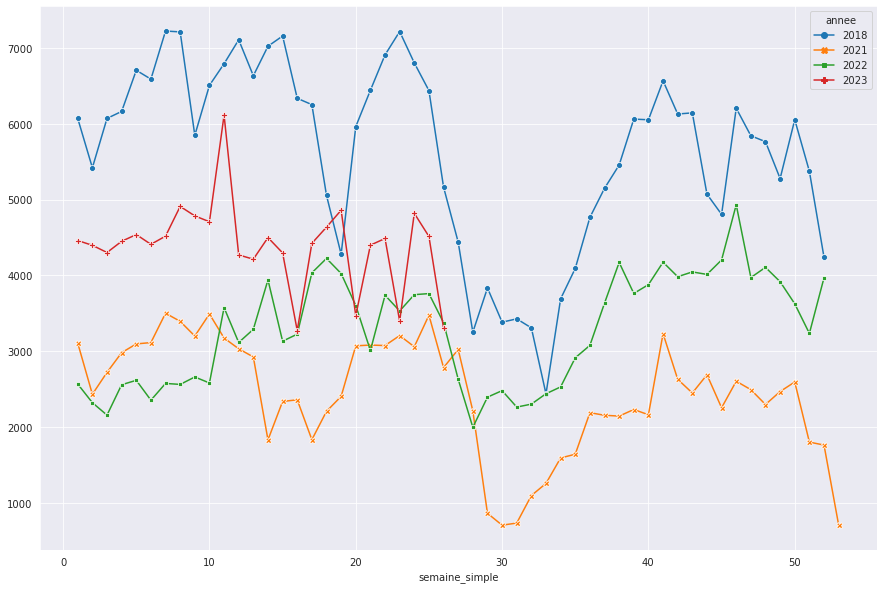

In [15]:
query = """
SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE YEAR(datetime) in (2018, 2021, 2022, 2023)
"""
entrees = StatActivite(db_conn=db_conn, query=query)
entrees.get_df_activite()

f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=entrees.df_activite, markers=True, dashes=False, ax=ax)
f.show()

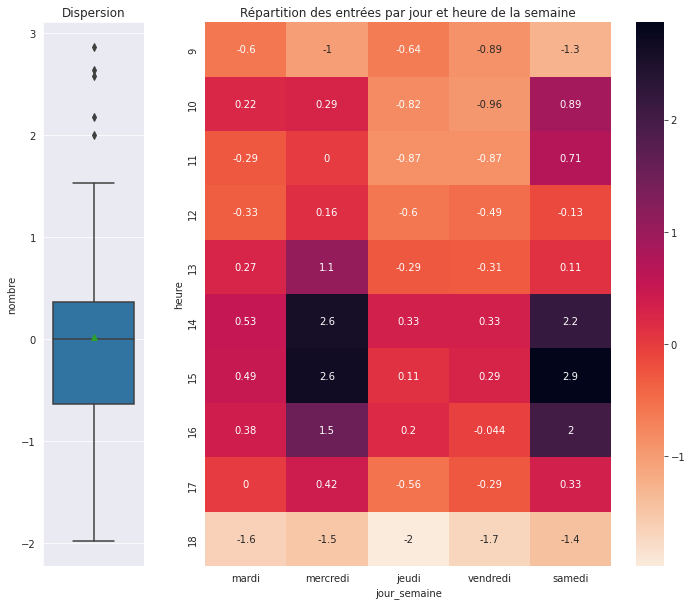

In [16]:
query = """
SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE YEAR(datetime) >= 2022
"""

entrees = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)
entrees.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = entrees.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(entrees.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

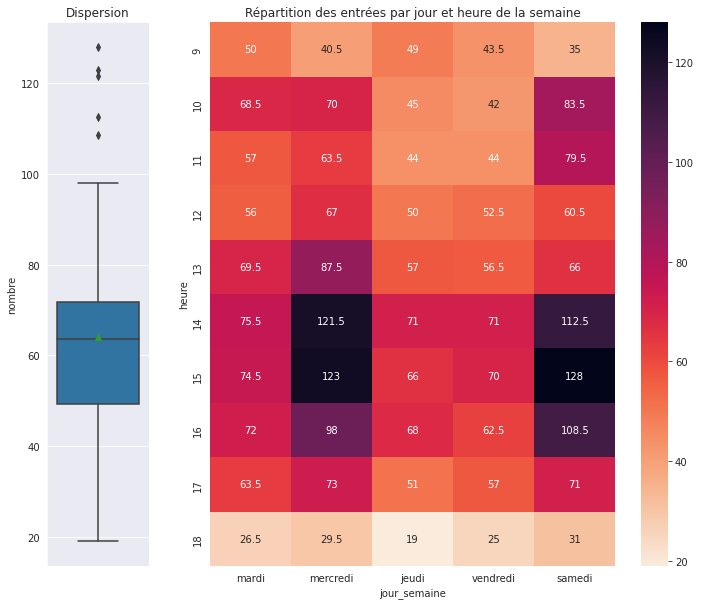

In [17]:
entrees.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = entrees.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(entrees.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g') 
ax[1].set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

## Prêts

## Comparaison pluri-annuelle

### Ensemble

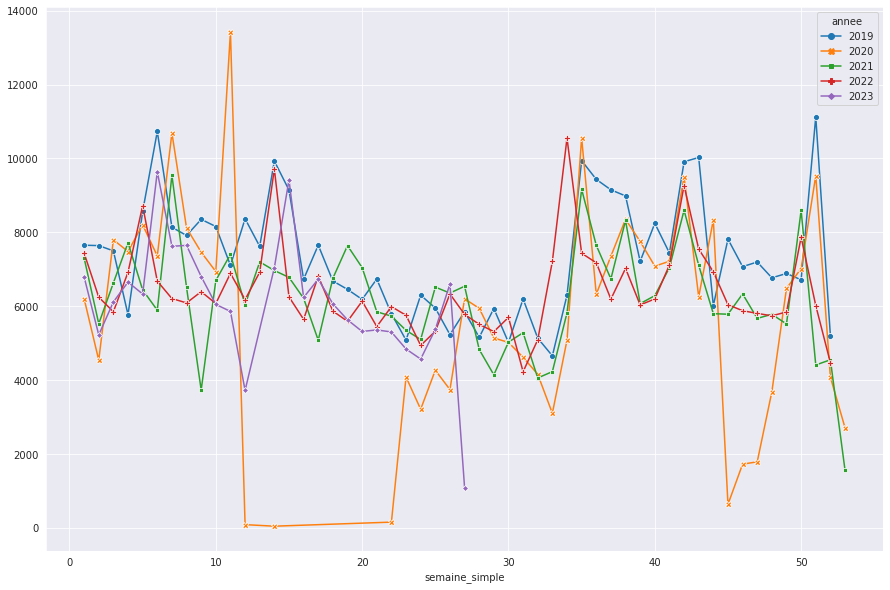

In [18]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2019-01-01'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activite()

f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=prets.df_activite, markers=True, dashes=False, ax=ax)
f.show()

### Médiathèque

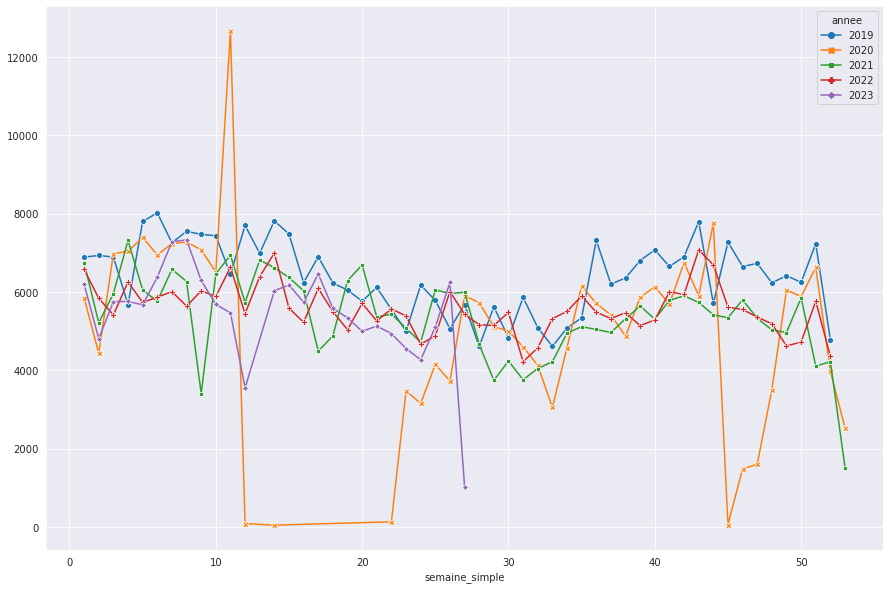

In [19]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2019-01-01' AND location NOT IN ('MED0A', 'BUS1A')
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activite()

f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=prets.df_activite, markers=True, dashes=False, ax=ax)
f.show()

### Zèbre

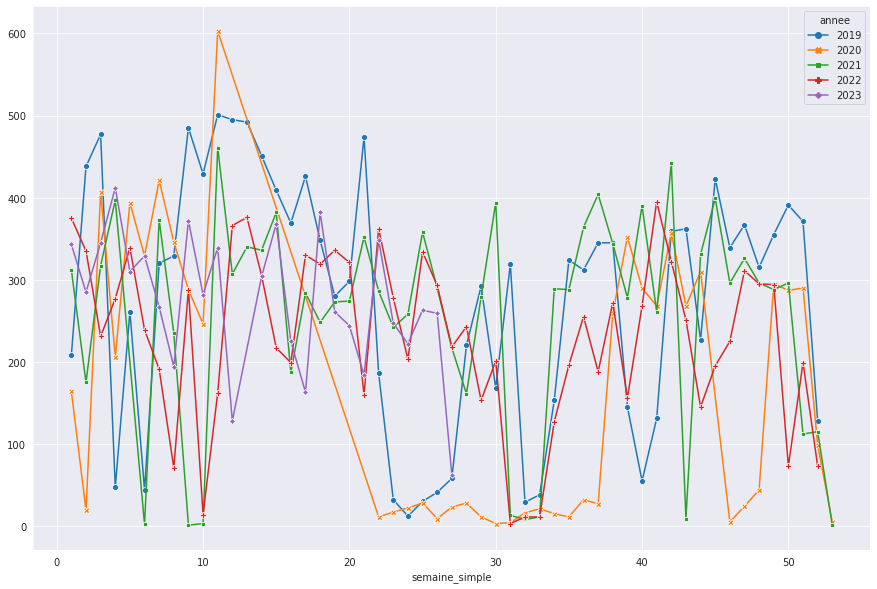

In [20]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2019-01-01' AND location = 'BUS1A'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activite()

f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=prets.df_activite, markers=True, dashes=False, ax=ax)
f.show()

### Collectivités

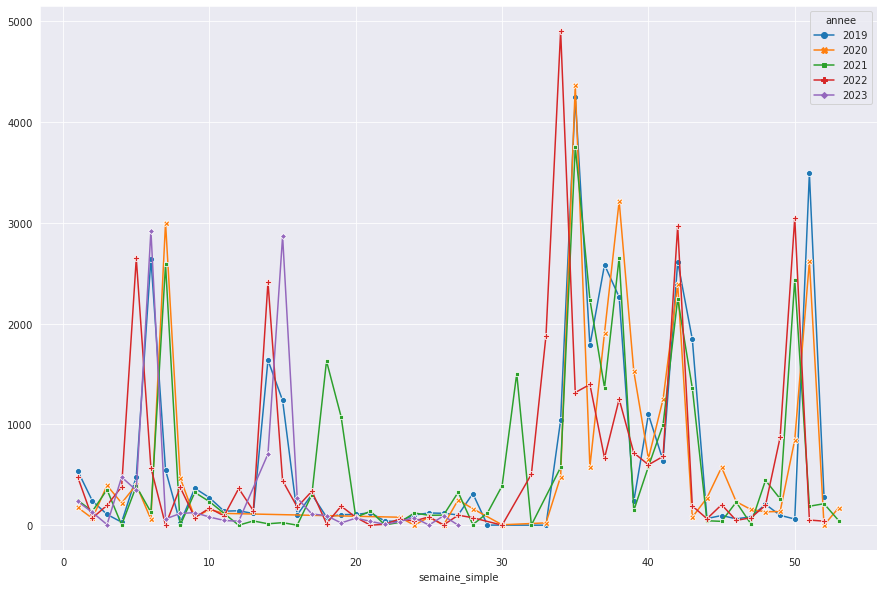

In [21]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2019-01-01' AND location = 'MED0A'
"""
prets = StatActivite(db_conn=db_conn, query=query)
prets.get_df_activite()

f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=prets.df_activite, markers=True, dashes=False, ax=ax)
f.show()

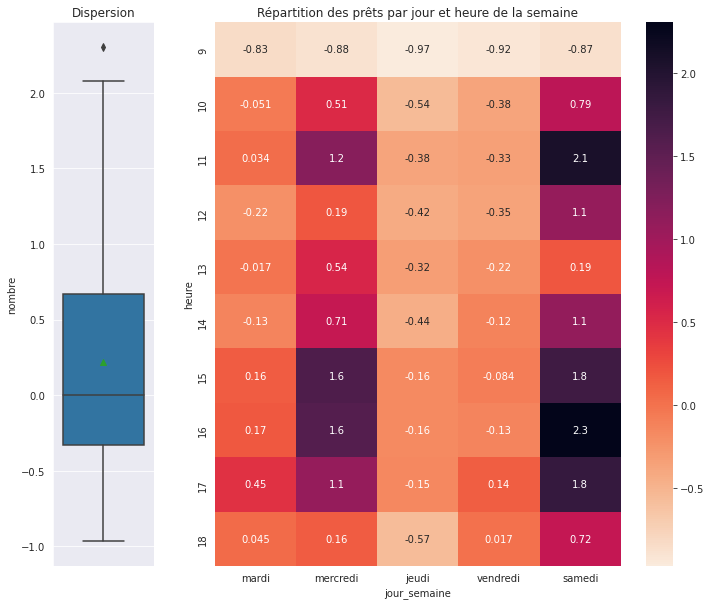

In [22]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(issuedate) >= '2022-01-01' AND location NOT IN ('MED0A', 'BUS1A')
"""

prets = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)
prets.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = prets.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(prets.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des prêts par jour et heure de la semaine")
f.show()

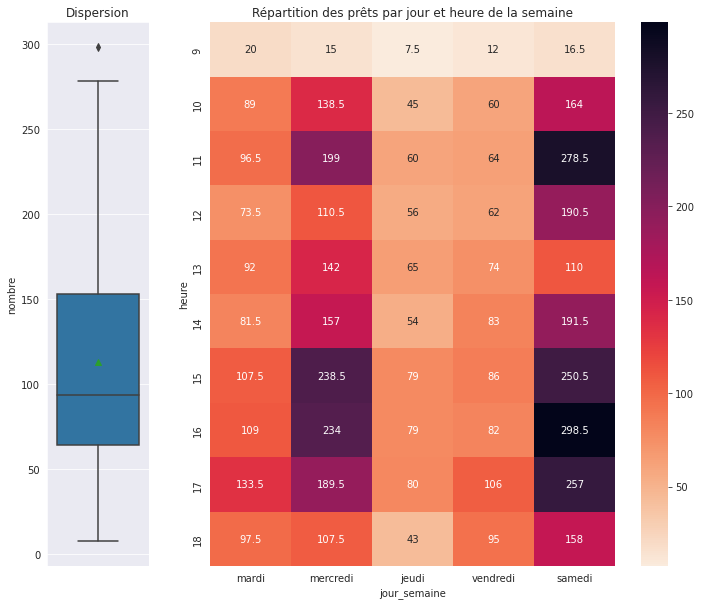

In [23]:
prets.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = prets.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(prets.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g' )
ax[1].set_title("Répartition des prêts par jour et heure de la semaine")
f.show()

## Retours

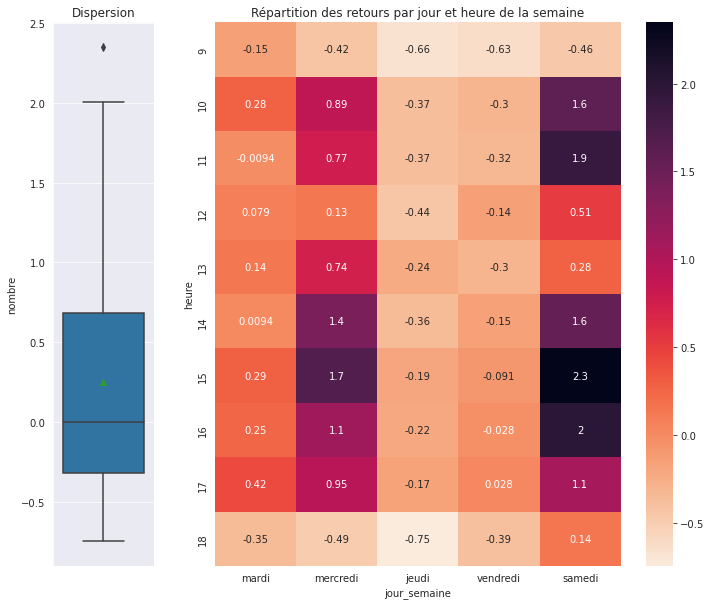

In [24]:
query = """
SELECT returndate as date_heure, borrowernumber as usager
FROM stat_issues
WHERE DATE(returndate) >= '2022-01-01' AND location NOT IN ('MED0A', 'BUS1A')
"""

retours = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)
retours.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = retours.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(retours.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des retours par jour et heure de la semaine")
f.show()

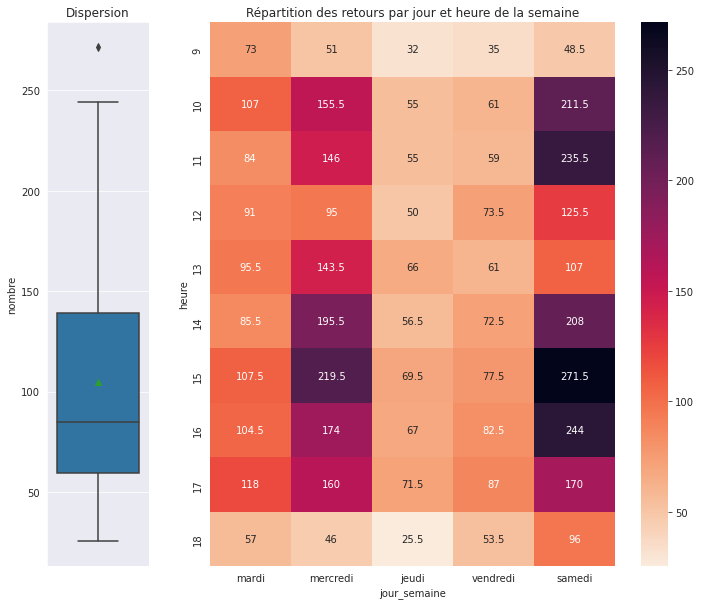

In [25]:
retours.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = retours.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(retours.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g' ) #fmt='g', 
ax[1].set_title("Répartition des retours par jour et heure de la semaine")
f.show()

## Webkiosk

In [26]:
query = """
SELECT heure_deb as date_heure, borrowernumber as usager
FROM stat_webkiosk
WHERE DATE(heure_deb) >= '2022-01-01'
"""

wk = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)

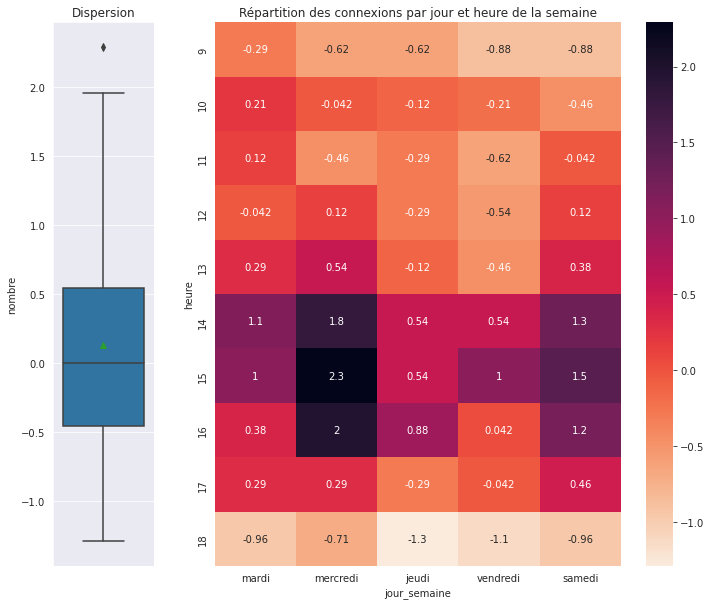

In [27]:
wk.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = wk.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(wk.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des connexions par jour et heure de la semaine")
f.show()

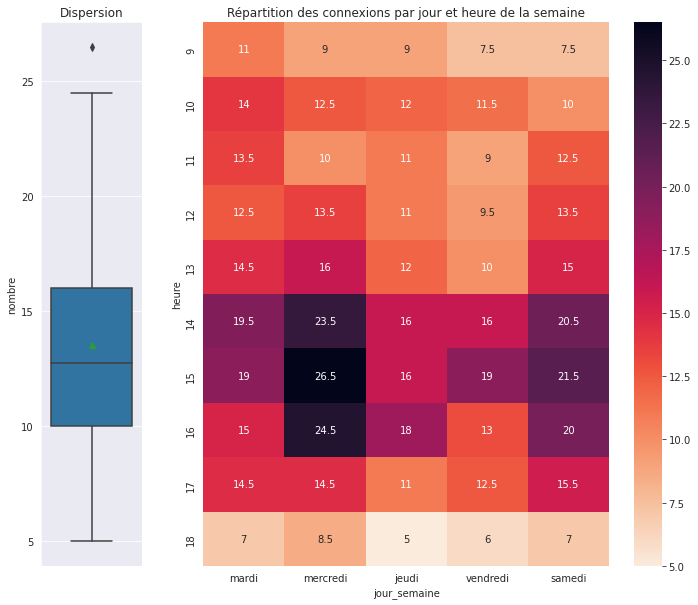

In [28]:
wk.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = wk.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(wk.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g' ) #fmt='g', 
ax[1].set_title("Répartition des connexions par jour et heure de la semaine")
f.show()

## Salle étude

In [29]:
query = """
SELECT datetime_entree as date_heure, borrowernumber as usager
FROM stat_freq_etude
WHERE DATE(datetime_entree) >= '2022-01-01'
"""

etude = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)

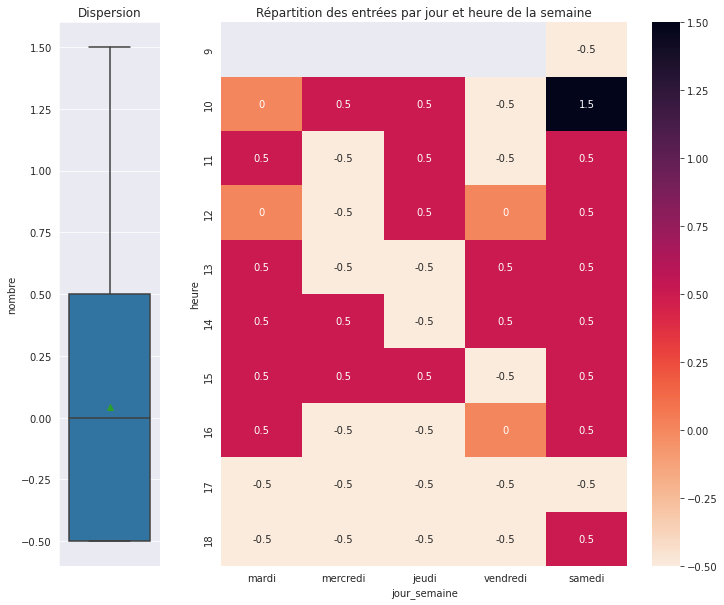

In [30]:
etude.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = etude.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(etude.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

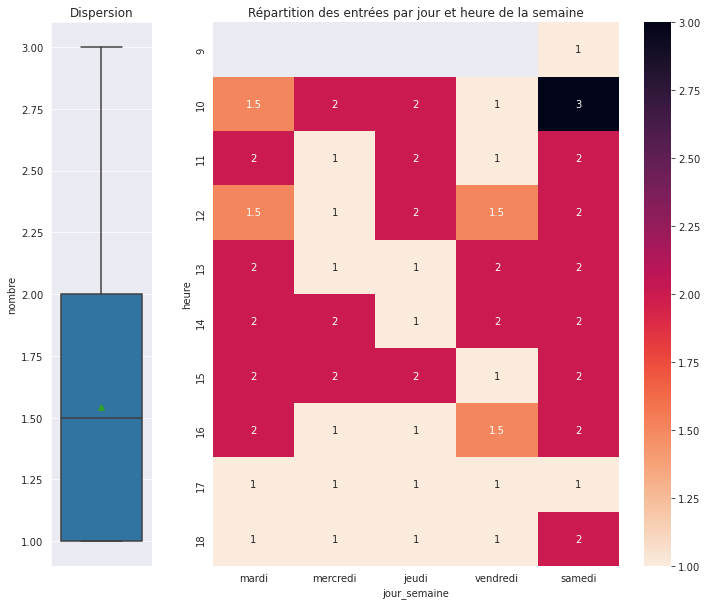

In [31]:
etude.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = etude.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(etude.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g')
ax[1].set_title("Répartition des entrées par jour et heure de la semaine")
f.show()

## Réservations (retraits)

In [32]:
query = """
SELECT issuedate as date_heure, borrowernumber as usager
FROM stat_reserves
WHERE DATE(issuedate) >= '2022-01-01'
"""

resas = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires)

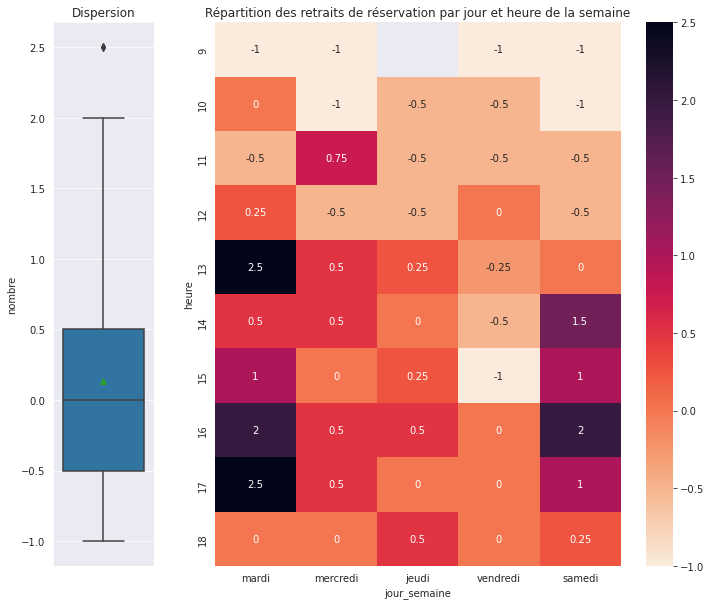

In [33]:
resas.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = resas.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(resas.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des retraits de réservation par jour et heure de la semaine")
f.show()

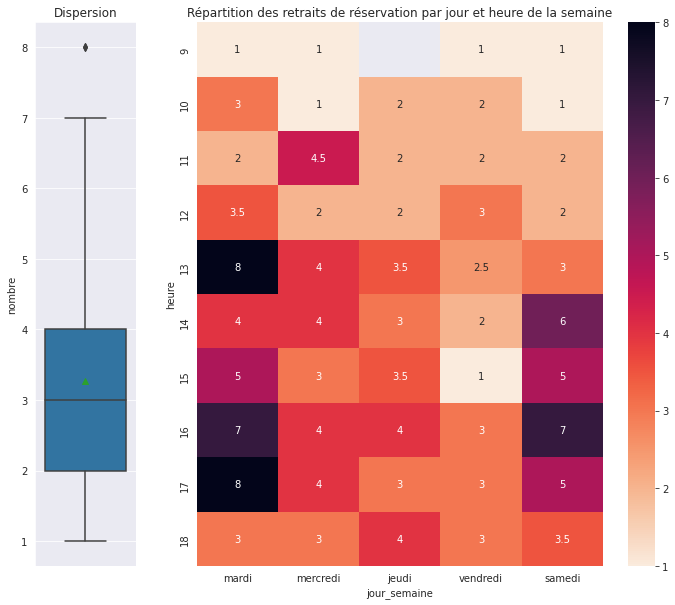

In [34]:
resas.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = resas.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(resas.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1], fmt='g')
ax[1].set_title("Répartition des retraits de réservation par jour et heure de la semaine")
f.show()

## Inscriptions

In [35]:
query = """
SELECT dateenrolled as date_heure, borrowernumber as usager
FROM koha_prod.borrowers
WHERE DATE(dateenrolled) >= '2022-01-01'
"""

insc = StatActivite(db_conn=db_conn, query=query, semaines=semaines_scolaires, inscriptions=True)

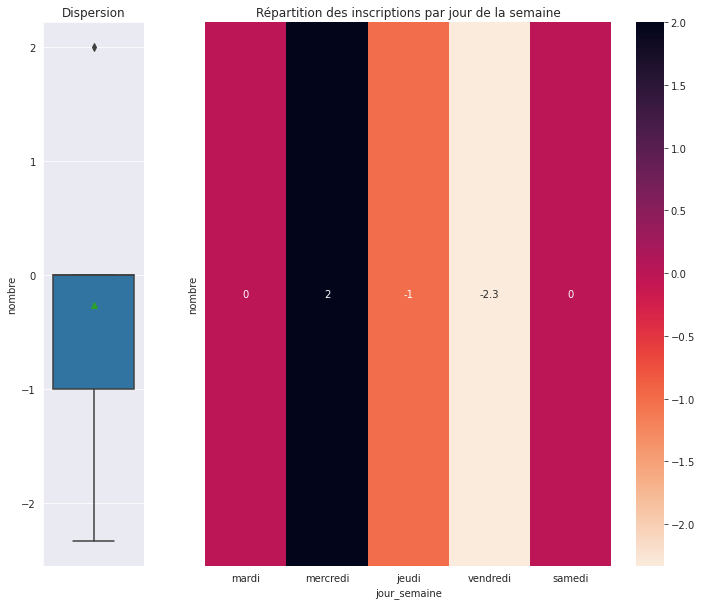

In [36]:
insc.get_df_semaine_activite(rescale=True)
f, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1, 5]})
sns.boxplot(data = insc.df_semaine_activite, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.heatmap(insc.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[1]) #fmt='g', 
ax[1].set_title("Répartition des inscriptions par jour de la semaine")
f.show()

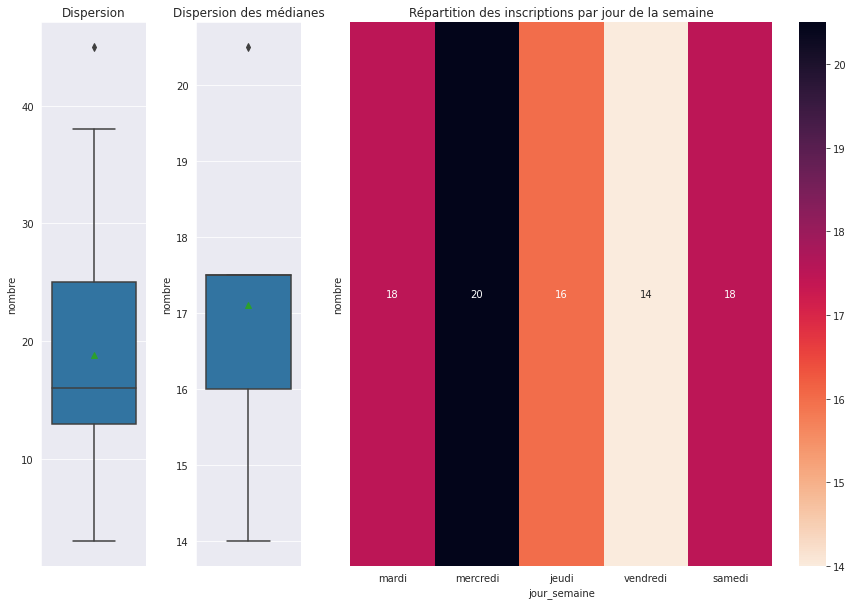

In [37]:
insc.get_df_semaine_activite(rescale=False)
f, ax = plt.subplots(1, 3, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1, 5]})
sns.boxplot(data = insc.df_semaine_activite_, y = 'nombre', ax=ax[0], orient = 'v', showmeans=True)
ax[0].set_title("Dispersion")
sns.boxplot(data = insc.df_semaine_activite, y = 'nombre', ax=ax[1], orient = 'v', showmeans=True)
ax[1].set_title("Dispersion des médianes")
sns.heatmap(insc.df_semaine_activite_pivot, cmap='rocket_r', annot=True, ax=ax[2]) #fmt='g', 
ax[2].set_title("Répartition des inscriptions par jour de la semaine")
f.show()